<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Восстановление золота из руды

В данной работе будет подготовлен прототип модели машинного обучения для компании «Цифры», разрабатывающей решения для эффективной работы промышленных предприятий. 
Модель будет предсказывать коэффициент восстановления золота из золотосодержащей руды, для этого компания предоставила  данные с параметрами добычи и очистки. Такая модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
Изначально данные разделенны на:
* `gold_recovery_train_new.csv` — обучающая выборка;
* `gold_recovery_test_new.csv` — тестовая выборка;
* `gold_recovery_full_new.csv` — исходные данные.

_Стоит отметить._  
Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков. 

__Описание данных__  
_Технологический процесс:_
* `Rougher feed` — исходное сырье
* `Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant
* `Xanthate**`— ксантогенат (промотер, или активатор флотации);
* `Sulphate` — сульфат (на данном производстве сульфид натрия);
* `Depressant` — депрессант (силикат натрия).
* `Rougher process` (англ. «грубый процесс») — флотация
* `Rougher tails` — отвальные хвосты
* `Float banks` — флотационная установка
* `Cleaner process` — очистка
* `Rougher Au` — черновой концентрат золота
* `Final Au` — финальный концентрат золота  
_Параметры этапов_
* `air amount` — объём воздуха
* `fluid levels` — уровень жидкости
* `feed size` — размер гранул сырья
* `feed rate` — скорость подачи  
_Наименование признаков_
Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]
Возможные значения для блока [этап]:
* `rougher` — флотация
* `primary_cleaner` — первичная очистка
* `secondary_cleaner` — вторичная очистка
* `final` — финальные характеристики  
Возможные значения для блока [тип_параметра]:
* `input` — параметры сырья
* `output` — параметры продукта
* `state` — параметры, характеризующие текущее состояние этапа
* `calculation` — расчётные характеристики  

__Задача модели.__  
Cпрогнозировать сразу две величины:
* эффективность обогащения чернового концентрата `rougher.output.recovery`;
* эффективность обогащения финального концентрата `final.output.recovery`.

## Подготовка данных

Для начала импортируем все необходимые библиотеки для данной работы.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.dummy import DummyRegressor

#Для удаленя предупреждений
import warnings 
warnings.simplefilter('ignore')

Зададим переменные которые будут хранить в себе все датасеты предоставленные компанией.

In [2]:
#Полные данные 
data_all = pd.read_csv('datasets/gold_industry_full.csv')
#Выборка для обучения с целевым признаком
data_train = pd.read_csv('datasets/gold_industry_train.csv')
#Тестовая выборка без целевого признака 
data_test = pd.read_csv('datasets/gold_industry_test.csv')

Перед подготовкой данных проверим один из целевой признак находящийся в переменной обучающей выборки `data_train`. Проверять будем колонку `rougher.output.recovery`. Сформулируем формулу для расчета эффективности обогащения, а после при помощи заданных и вычисленных значений расчитаем метрики качества `МАЕ` между ними, она покажет величину средней абсолютной разницы.

_Формула для расчета эффективности обогащения ._

$$Recovery = \frac{C*(F-T)}{F*(C-T)}*100\%$$

где:
* $C$ — доля золота в концентрате после флотации/очистки;
* $F$ — доля золота в сырье/концентрате до флотации/очистки;
* $T$ — доля золота в отвальных хвостах после флотации/очистки.

Теперь зададим переменные хранящие все необходимые данные для вычисления эффективности обогащения. 

In [3]:
#доля золота в концентрате после флотации/очистки
C = data_train['rougher.output.concentrate_au']
#доля золота в сырье/концентрате до флотации/очистки
F = data_train['rougher.input.feed_au']
#доля золота в отвальных хвостах после флотации/очистки
T = data_train['rougher.output.tail_au']

Теперь рассчитаем эффективность

In [4]:
recovery = (C*(F-T))/(F*(C-T))*100
#Прверка 
recovery.head()

0    84.814586
1    86.013484
2    87.457294
3    87.394321
4    86.448262
dtype: float64

Тепрь возьмем полученную колонку с данными и `rougher.output.recovery` колонку из предоставленного датасета. Расчитаем метрику `MAE`.

In [5]:
print('Значение МАЕ:', 
      mean_absolute_error(data_train['rougher.output.recovery'], recovery))

Значение МАЕ: 9.901274415917823e-15


_Значение средней абсолютной разницы карйне мало, что говорит о достоверности предоставленных данных, можно с уверенностью использовать их при обучении моделей._

Наши таблицы имеют разное количество колонок. посмотрим как сильно они отличаются и какие именно данные отсутствуют.

In [6]:
print('Колонки отсутствующие в data_test:\n')
for i in data_train.columns:
    if i not in data_test.columns:
        print(i)

Колонки отсутствующие в data_test:

Unnamed: 0.5
Unnamed: 0.4
Unnamed: 0.3
Unnamed: 0.2
Unnamed: 0.1
Unnamed: 0
rougher.calculation.sulfate_to_au_concentrate
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.calculation.floatbank11_sulfate_to_au_feed
rougher.calculation.au_pb_ratio
rougher.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_au
rougher.output.tail_ag
rougher.output.tail_pb
rougher.output.tail_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
primary_cleaner.output.tail_au
primary_cleaner.output.tail_ag
primary_cleaner.output.tail_pb
primary_cleaner.output.tail_sol
secondary_cleaner.output.tail_au
secondary_cleaner.output.tail_ag
secondary_cleaner.output.tail_pb
secondary_cleaner.output.tail_sol
final.output.concentrate_au
final.output.concentrate_ag
fin

_В основном отсутствуют колонки хранящие выходные данные после всем манипуляций с рудой, об этом на говорит название параметра `output`. Это вполне логично так как, данные параметры сообщают нам итоговые параметры, которые и нужно предсказать по вводным данным, и при проверки модели такие характреистики будут лишними. А вот для обучения они необходимы. А вот колонки с названием параметра `calculation`, хранят в себе расчетные характеристики для флотации. Таких данных нет в тестовой, и в будующем это помешает предсказать по тестовой выборке целевые значения, так как модель будет пытать использовать данные которых нет. Стоит исключить их при обучении будующих моделей._

Проведем предобработку предоставленных таблиц.

 __Выборка для обучения моделей.__

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8279 entries, 0 to 8278
Data columns (total 93 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   Unnamed: 0.5                                        8279 non-null   int64  
 1   Unnamed: 0.4                                        8279 non-null   int64  
 2   Unnamed: 0.3                                        8279 non-null   int64  
 3   Unnamed: 0.2                                        8279 non-null   int64  
 4   Unnamed: 0.1                                        8279 non-null   int64  
 5   Unnamed: 0                                          8279 non-null   int64  
 6   date                                                8279 non-null   object 
 7   rougher.input.feed_au                               8279 non-null   float64
 8   rougher.input.feed_ag                               8279 non-null   float64
 9

Название и типы колонок, соответствуют нашим требованиям. Также в таблице присутствуют пропуски и колонки которые не потребуются для обучения моделей. Так же присутствует колонка `date` которая также не потребуется для обучения. Сначала посмотрим на пропуски.

In [8]:
#Вывод всех колонок с пропусками и их общее количество.
print('Колличество всех пропусков',
      data_train.isna().sum()[(data_train.isna().sum()>0)].sum())
data_train.isna().sum()[(data_train.isna().sum()>0)]

Колличество всех пропусков 2464


rougher.input.feed_pb                                  63
rougher.input.feed_sol                                 41
rougher.input.feed_rate                                 7
rougher.input.feed_size                                 6
rougher.input.floatbank10_sulfate                      28
rougher.input.floatbank10_xanthate                      7
rougher.state.floatbank10_e_air                       429
rougher.input.floatbank11_sulfate                      33
rougher.input.floatbank11_xanthate                    392
rougher.calculation.sulfate_to_au_concentrate           1
rougher.calculation.floatbank10_sulfate_to_au_feed      1
rougher.calculation.floatbank11_sulfate_to_au_feed      1
rougher.output.concentrate_sol                         13
primary_cleaner.input.sulfate                          17
primary_cleaner.input.depressant                       15
primary_cleaner.input.xanthate                         48
primary_cleaner.state.floatbank8_a_air                  3
primary_cleane

Пропусков достаточно большое количество. И находятся они в 62 колонках. Удалять их будет неправильным, так как потеря такого большого количества данных будет ошибкой. Но их нужно запонить так как обучить модель с пропусками в данных не получится. Ноперед тем как заполнять их стоит исключить из обучающей выборки все ненужные колонки, которые отсутствуют в выборке для теста, а также сохраним колонки с целевыми признаками.

In [9]:
#Создаем список со всеми необходимыми колонками
columns_for_train = list(data_test.columns)
columns_for_train.extend(['final.output.recovery',
                        'rougher.output.recovery'])
print('Колличество колонок в обучающей выборке', len(columns_for_train))
print('Количество колонок в тестовой выборке', data_test.shape[1])

Колличество колонок в обучающей выборке 55
Количество колонок в тестовой выборке 53


Получится что в новой обучающей выборке будет ровно на два целевых признака больше, что нам и нужно. Теперь исключим данные колонки из выборки, а также удалим колонку с датой.

In [10]:
#Новый датасет для обучения в сокращенном варианте.
data_train_short = data_train[columns_for_train].drop('date',axis=1)
data_train_short.head()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
0,10.541454,10.655165,3.991062,28.612776,354.617046,40.305708,11.449669,5.157384,1493.707771,-300.000292,...,23.038878,-400.267771,23.048501,-453.024673,19.991403,-450.697855,25.014363,-599.692088,43.216713,84.814586
1,10.218859,10.589197,3.815051,36.029721,386.602632,44.405363,12.000902,5.501515,1499.749342,-299.946860,...,23.018276,-400.321568,22.999819,-448.101512,20.000746,-449.877079,25.019034,-598.135381,54.303094,86.013484
2,10.251907,10.459074,3.848392,36.780163,414.800822,47.540082,12.999204,5.931941,1499.003673,-300.479294,...,22.950066,-400.041434,23.020168,-448.204864,20.004751,-449.997049,25.013455,-597.959874,63.975268,87.457294
3,9.958958,9.987284,3.834882,38.910239,415.690381,51.634926,13.011036,6.017776,1499.098285,-300.144037,...,23.003890,-399.670796,22.983392,-450.346822,20.014109,-449.705197,25.016112,-501.003741,61.927558,87.394321
4,9.853358,9.774808,3.850639,38.667543,418.217465,54.556275,12.995792,6.198225,1502.699684,-300.065897,...,23.016138,-400.373036,22.974736,-449.598448,19.997314,-450.051142,24.984056,-499.606747,61.546846,86.448262


Теперь разбиремся с пропусками.

In [11]:
#Вывод всех колонок с пропусками и их общее количество.
print('Колличество всех пропусков',
      data_train_short.isna().sum()[(data_train.isna().sum()>0)].sum())
data_train_short.isna().sum()[(data_train_short.isna().sum()>0)]

Колличество всех пропусков 1213


rougher.input.feed_pb                        63
rougher.input.feed_sol                       41
rougher.input.feed_rate                       7
rougher.input.feed_size                       6
rougher.input.floatbank10_sulfate            28
rougher.input.floatbank10_xanthate            7
rougher.state.floatbank10_e_air             429
rougher.input.floatbank11_sulfate            33
rougher.input.floatbank11_xanthate          392
primary_cleaner.input.sulfate                17
primary_cleaner.input.depressant             15
primary_cleaner.input.xanthate               48
primary_cleaner.state.floatbank8_a_air        3
primary_cleaner.state.floatbank8_b_air        3
secondary_cleaner.state.floatbank2_a_air     94
secondary_cleaner.state.floatbank2_b_air     19
secondary_cleaner.state.floatbank3_a_air      2
secondary_cleaner.state.floatbank4_a_air      5
secondary_cleaner.state.floatbank6_a_air      1
dtype: int64

Пропусков стало в разы меньше, есть большое количество колонок в которых пропусков очень мало, но также присутствуют колонки с пропусками больше 400 позиций, посмотрим на статистические показатели таких колонок в которых количество пропусков достигает 100 позиций.

In [12]:
(
    data_train_short[['primary_cleaner.input.xanthate', 
                'rougher.input.feed_pb',
                'rougher.input.feed_size', 
                'rougher.input.floatbank11_xanthate', 
                'rougher.state.floatbank10_e_air', 
                'secondary_cleaner.state.floatbank2_a_air',]
              ]
    .apply (['mean', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)


,primary_cleaner.input.xanthate,rougher.input.feed_pb,rougher.input.feed_size,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_e_air,secondary_cleaner.state.floatbank2_a_air
mean,1.09,3.86,64.93,6.06,"1,022.33",29.66
min,0.00,0.01,0.05,0.00,-1.98,0.14
max,4.10,7.05,484.97,9.30,"1,922.64",52.65
median,0.99,3.77,58.72,6.20,"1,000.30",30.03


Видно что в данных колонках, медиана и среднее арифметическое практически равны. Построим гистограммы, для дальнейшего отслеживания статических параметров колонок.

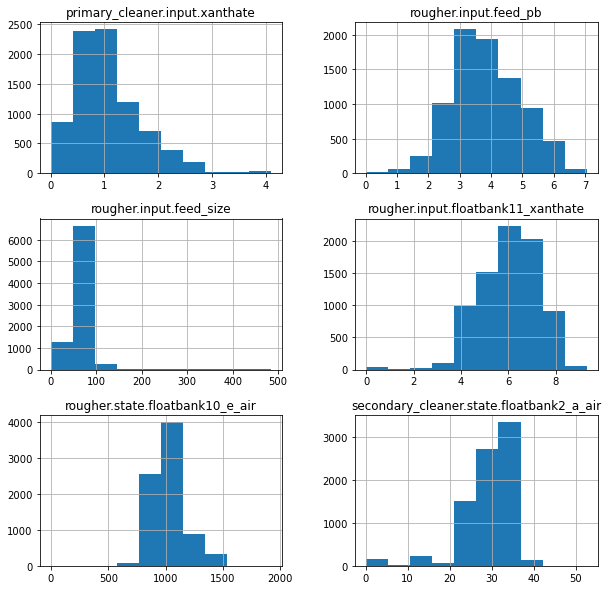

In [13]:
data_train_short[['primary_cleaner.input.xanthate', 
                'rougher.input.feed_pb',
                'rougher.input.feed_size', 
                'rougher.input.floatbank11_xanthate', 
                'rougher.state.floatbank10_e_air', 
                'secondary_cleaner.state.floatbank2_a_air']].hist(figsize=(10,10));

Графики построенны, теперь заполним пропуски меданным значением соответствующих колонок, а после посмотрим насколько изменились графики и метрики.

In [14]:
for i in ['primary_cleaner.input.xanthate', 
          'rougher.input.feed_pb',
          'rougher.input.feed_size', 
          'rougher.input.floatbank11_xanthate', 
          'rougher.state.floatbank10_e_air', 
          'secondary_cleaner.state.floatbank2_a_air']:
    
    data_train_short[i] = data_train_short[i].fillna(data_train_short[i].median())
print('Колличество всех пропусков',
      data_train_short.isna().sum()[(data_train_short.isna().sum()>0)].sum())

Колличество всех пропусков 181


Колличество пропусков заметно уменьшилось. Посмотрим как это повлияло на наши данные.

In [15]:
(
    data_train_short[['primary_cleaner.input.xanthate', 
                'rougher.input.feed_pb',
                'rougher.input.feed_size', 
                'rougher.input.floatbank11_xanthate', 
                'rougher.state.floatbank10_e_air', 
                'secondary_cleaner.state.floatbank2_a_air',]
              ]
    .apply (['mean', 'min', 'max', 'median'])   
    .style.format("{:,.2f}")
)


,primary_cleaner.input.xanthate,rougher.input.feed_pb,rougher.input.feed_size,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_e_air,secondary_cleaner.state.floatbank2_a_air
mean,1.09,3.86,64.92,6.06,"1,021.19",29.67
min,0.00,0.01,0.05,0.00,-1.98,0.14
max,4.10,7.05,484.97,9.30,"1,922.64",52.65
median,0.99,3.77,58.72,6.20,"1,000.30",30.03


По статистическим характеристикам, все хорошо, сильных искажений по параметром замеченно не было. Посмотрим на гистограммы.

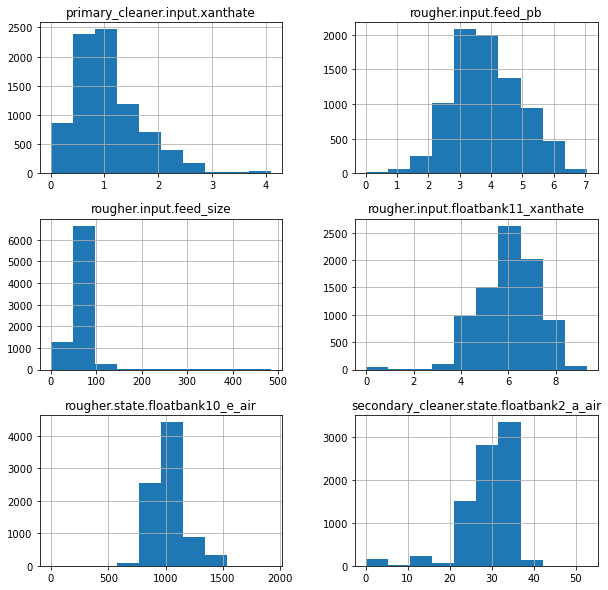

In [16]:
data_train_short[['primary_cleaner.input.xanthate', 
                'rougher.input.feed_pb',
                'rougher.input.feed_size', 
                'rougher.input.floatbank11_xanthate', 
                'rougher.state.floatbank10_e_air', 
                'secondary_cleaner.state.floatbank2_a_air']].hist(figsize=(10,10));

Видно небольшое увеличесние в районе средних значений, но заполнение данными значениями не привело к сильному искажению картинки и изменению порядков значений характеристик. Оставим такое заполнение. Остальные же заполним нулями, так как их количество слишком мало по сравнению с остальным датасетом.

In [17]:
data_train_short = data_train_short.fillna(0)
#Проверка
print('Колличество всех пропусков',
      data_train_short.isna().sum()[(data_train_short.isna().sum()>0)].sum())

Колличество всех пропусков 0


Проверим датасет на дубликаты.

In [18]:
print('Количество полных дубликатов', data_train_short.duplicated().sum())

Количество полных дубликатов 0


Такие отсутсвуют, приступим к предобработке тестовой выборки.

__Тестовая выборка__

Дейсствуем по аналогии с выборкой для обучения.

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

В данной колонке также все хорошо с типами и названиями. Пропуски присутствуют, также необходимо исключить колонку `date`. Но сначала с ее помощью достанем из основного датасета целевые признаки для тестовой выборки. Но сначала проверим уникально ли каждое значение колонки `date`.

In [20]:
assert len(data_all.date.unique()) == data_all.shape[0], 'Есть одинаковые даты'
print('Все даты уникальны.')

Все даты уникальны.


Отлично, теперь спокойно можно достать из основного датасета целевые признаки для тестовой выборки.

In [21]:
# Выбираем только строки с теми же датами что и у тестовой выборки
target_test = (data_all.loc[data_all['date'].isin(data_test.date.tolist())][
                ['date',
                 'rougher.output.recovery', 
                 'final.output.recovery']  # выбираем только целевые признаки и дату для проверки с тестовой.
                                                                            ] 
               .reset_index(drop=True) # обновляем индексы
              )
assert target_test.shape[0] == data_test.shape[0], 'Не соответсвует размеру тестовой выборки'
target_test

,date,rougher.output.recovery,final.output.recovery
0,2017-12-09 14:59:59,89.514960,70.281454
1,2017-12-09 15:59:59,89.858126,65.523246
2,2017-12-09 16:59:59,91.816623,74.817644
3,2017-12-09 17:59:59,88.478959,63.082720
4,2017-12-09 18:59:59,89.230316,74.463380
...,...,...,...
4855,2018-08-18 06:59:59,85.462226,68.786981
4856,2018-08-18 07:59:59,85.443505,67.839536
4857,2018-08-18 08:59:59,87.235441,70.847012
4858,2018-08-18 09:59:59,89.299981,72.659046


По выведенной таблице можно отследить индексы и значение `date`. Теперь посмотрим на индексы и дату в тестовой выборки, чтобы понять правильно ли распределились целевые значения по индексам

In [22]:
data_test.date

0       2017-12-09 14:59:59
1       2017-12-09 15:59:59
2       2017-12-09 16:59:59
3       2017-12-09 17:59:59
4       2017-12-09 18:59:59
               ...         
4855    2018-08-18 06:59:59
4856    2018-08-18 07:59:59
4857    2018-08-18 08:59:59
4858    2018-08-18 09:59:59
4859    2018-08-18 10:59:59
Name: date, Length: 4860, dtype: object

Все правильно, теперь можно смело удалить колонку `date` из тестовой выборки и проверить на наличие пропусков.

In [23]:
data_test = data_test.drop('date', axis=1)
print('Колличество всех пропусков',
      data_test.isna().sum()[(data_test.isna().sum()>0)].sum())
data_test.isna().sum()[(data_test.isna().sum()>0)]

Колличество всех пропусков 375


rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_e_air                 7
rougher.input.floatbank11_sulfate               8
rougher.input.floatbank11_xanthate             46
primary_cleaner.input.sulfate                   1
primary_cleaner.input.depressant                9
primary_cleaner.input.xanthate                 43
primary_cleaner.state.floatbank8_a_air          1
primary_cleaner.state.floatbank8_a_level        1


In [24]:
data_test = data_test.fillna(0)
print('Колличество всех пропусков',
      data_test.isna().sum()[(data_test.isna().sum()>0)].sum())

Колличество всех пропусков 0


In [25]:
data_train.duplicated().sum()

0

Проверим датасет на дубликаты.

In [26]:
print('Количество полных дубликатов', data_test.duplicated().sum())

Количество полных дубликатов 0


Такие отсутсвуют, все данные готовы к дальнейшей работе. 

__Вывод__  
В данной части, были подготовленны две выборки. Были удаленны ненужные колонки и заполненны все пропуски. Для тестовой выборки были отобранны целевые признаки из основного датасета, для тестирования в будующем обученной модели. Также датасеты были проверенны на полные дубликаты. Также был проверен один из ключевых признаков на корректность с помощью метрики `MAE`.

## Анализ данных

Анализ данных будем проводить по датасету со всеми данными, так как обобщенные данные помогут более четко понять зависимости и статистики данных.

__Для начала посмотрим как менялась концентрация металлов на каждом из этапов отчистки.__

Сначала найдем колонки с такими данными.

In [27]:
#Выведем все колонки с 'concentrate' в названии, а также 'rougher.input.feed_' для определения сырья для каждого элемента
for i in data_all.columns:
    if 'concentrate' in i or 'rougher.input.feed_' in i:
        print(i)

rougher.input.feed_au
rougher.input.feed_ag
rougher.input.feed_pb
rougher.input.feed_sol
rougher.input.feed_rate
rougher.input.feed_size
rougher.calculation.sulfate_to_au_concentrate
rougher.output.concentrate_au
rougher.output.concentrate_ag
rougher.output.concentrate_pb
rougher.output.concentrate_sol
primary_cleaner.output.concentrate_au
primary_cleaner.output.concentrate_ag
primary_cleaner.output.concentrate_pb
primary_cleaner.output.concentrate_sol
final.output.concentrate_au
final.output.concentrate_ag
final.output.concentrate_pb
final.output.concentrate_sol


Такие данные присутствует для элементов `ag, pb, sol и au` на каждом из этапов обработки руды, так как рассматриваемый вопрос относится только к металлам, элемент `sol`(Натрий) мы откинем. Также были выведенны ненужные колонки `rougher.calculation.sulfate_to_au_concentrate`, `rougher.input.feed_size` и `rougher.input.feed_rate` для данного исследования.

Для поставленного вопроса, создадим функцию которая построит график распределения с помощью функции `kdeplot` библиотеки `sns` на каждый этап отчистки, и расчитает общую концентрацию и среднее арифметическое для каждого этапа.

In [28]:
def graf_concentrate_element(data:'DataFrame', element:str):
    
    '''Функция берет на вход датафрейм с определенным названием типичных колонок, 
    также берет второй параметр обозначающий нужный элемент для работы в формате str'''
    
    try:
        #Создаем три переменный для каждого этапа для уменьшения кода
        raw_material = 'rougher.input.feed_' + element
        rougher = 'rougher.output.concentrate_' + element
        primary = 'primary_cleaner.output.concentrate_' + element
        final = 'final.output.concentrate_' + element
        
        #Ресуем три гистограммы для каждого этапа отчистки
        
        sns.kdeplot(data[raw_material], 
                    shade=True, 
                    label='Сырье'
                   )
        
        sns.kdeplot(data[rougher], 
                    shade=True, 
                    label='Флотация'
                   )
        sns.kdeplot(data[primary], 
                    shade=True,
                    label='Первичная отчистка'
                   )
        sns.kdeplot(data[final], 
                    shade=True,
                    label='Финальная отчистка'
                   )

       # Оформляем график 
        plt.title('Концентрация '+element+' на разных этапах отчистки.')
        plt.grid()
        plt.xlabel('Концентрация')
        plt.ylabel('Относительное количество данных по руде')
        plt.legend();
        
        
        #Вывести таблицу с общей массой и средним на каждом этапе отчистки
        return (data[[raw_material, rougher, primary, final]]
                .apply(['sum', 'mean'])
                .rename(columns={raw_material:'Сырье',
                                  rougher:'Флотация',
                                  primary:'Первичная отчситка',
                                  final:'Финальная отчистка'},
                        index={'sum':'Общий обьем',
                               'mean':'Среднее арифметическое'})
                )
    
    except:
        return print('Неверные параметры для функции')

Функция готова, можно приступать к анализу.

_Металл `ag` серебро._
___

,Сырье,Флотация,Первичная отчситка,Финальная отчистка
Общий обьем,114326.833905,156215.124787,109885.489367,66004.465767
Среднее арифметическое,8.701334,11.889423,8.363307,5.023553


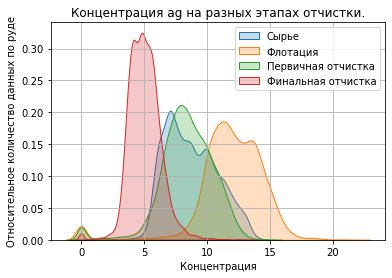

In [29]:
graf_concentrate_element(data_all, 'ag')

По таблице видно, что после флотации примесь серебра резко возросла, видимо данный этап отчистки, не предназначен для данного элемента. На последующих этапах концентрация практически вернулась к сырьевому значению, видимо комппания стремится к сохранению данного элемента. К финальной стадии отчистки график стремительно устремляется вверх в значении 5. Также можно увидить большое количество данных с нулем на этапе флотации, видимо это позиции находящиеся в позициях из тестовой выборки, их появление обьясняется использованием всего датасета, а данных позициях отсутствуют колонки с нужными значениями.

_Металл `pb` свинец._
___

,Сырье,Флотация,Первичная отчситка,Финальная отчистка
Общий обьем,49015.738057,103003.217192,134257.668792,133407.727895
Среднее арифметическое,3.756571,7.839502,10.272201,10.153568


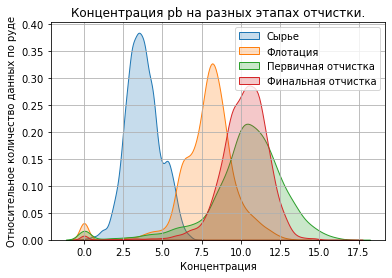

In [30]:
graf_concentrate_element(data_all, 'pb')

В случае свинца, можно сказать, что данные методы отчистки слабо помогают в избавление от данного элемента. Это видно и по таблице и по графику. Среднее значение к финальному этапу изменилась от 3 (на флотации) до 10. Также присутствуют позиции с значением нуль в позициях из тестовой выборки.

_Металл `au` золото._
___

,Сырье,Флотация,Первичная отчситка,Финальная отчистка
Общий обьем,107250.332662,253607.728218,413337.604759,581865.971625
Среднее арифметическое,8.162747,19.301905,31.458833,44.285408


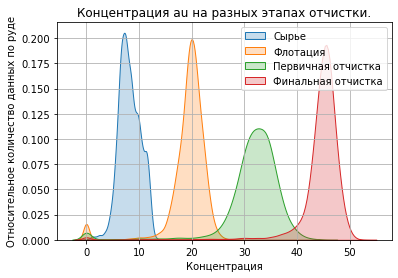

In [31]:
graf_concentrate_element(data_all, 'au')

По выводу функции можно заключить, что с каждым последующим этапом отчистки, концентрация золота стремительно растет. На финальном этапе достигает среднего арифмитечиеского в 44.

__Теперь анализируем распределение размеров гранул сырья на обучающей и тестовой выборках. Стоит отследить этот момен, так как если распределение сильно отличаются друг от друга, оценка модели будет некорректной.__

Построим две гистограммы на одном графике, для единоразового взгляда на распределение размера гранул.  
Будет построенно два графика, так как размер гранул в датасетах расчитан только на этапы флотации и первичной отчистки. Также в их легенде будет расчитанно среднее арифметическое по данному параметру в каждой выборке.

_Размер гранул на этапе флотации._
___

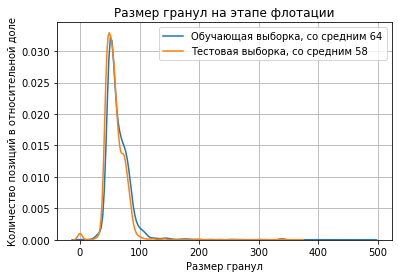

In [32]:
sns.kdeplot(data_train['rougher.input.feed_size'],
            label=('Обучающая выборка, со средним '
                   +str(int(data_train['rougher.input.feed_size'].mean())))
           )

sns.kdeplot(data_test['rougher.input.feed_size'],
            label=('Тестовая выборка, со средним '
                   +str(int(data_test['rougher.input.feed_size'].mean())))
           )
plt.grid()
plt.title('Размер гранул на этапе флотации')
plt.ylabel('Количество позиций в относительной доле')
plt.xlabel('Размер гранул')

plt.legend();

Средние арифметические отличаются не сильно, графики возвышаются практически на одном значении. Присутствуют слишком большие значения в каждой из выборок, проверим их статистики.

In [33]:
print('Обучающая выборка')
print('---------------------')
print(data_train['rougher.input.feed_size'].describe())
print('_____________________\n')
print('Тестовая выборка')
print('---------------------')
print(data_test['rougher.input.feed_size'].describe())
print('______________________')

Обучающая выборка
---------------------
count    8273.000000
mean       64.925177
std        26.660613
min         0.049194
25%        51.115490
50%        58.716396
75%        73.342147
max       484.967466
Name: rougher.input.feed_size, dtype: float64
_____________________

Тестовая выборка
---------------------
count    4860.000000
mean       58.578217
std        19.844763
min         0.000000
25%        47.580982
50%        55.382436
75%        66.531930
max       363.989699
Name: rougher.input.feed_size, dtype: float64
______________________


Выбоки достаточно похожи, есть небольшое расхождения по квантилям. Также максимальное значение в обучающей достаточно оторвалось от тестовой. Можно утверждать, что значения данного параметра в выборках подойдет для обучения модели и ее последующейго теста.

_Размер гранул на этапе первичной отчистки._
___

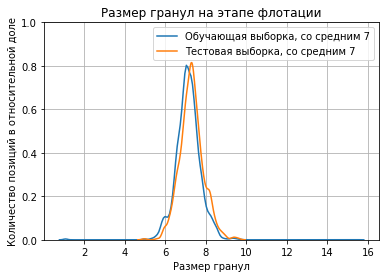

In [34]:
sns.kdeplot(data_train['primary_cleaner.input.feed_size'],
            label=('Обучающая выборка, со средним '
                   +str(int(data_train['primary_cleaner.input.feed_size'].mean())))
           )

sns.kdeplot(data_test['primary_cleaner.input.feed_size'],
            label=('Тестовая выборка, со средним '
                   +str(int(data_test['primary_cleaner.input.feed_size'].mean())))
           )

plt.ylim (0, 1) 
plt.grid()
plt.title('Размер гранул на этапе флотации')
plt.ylabel('Количество позиций в относительной доле')
plt.xlabel('Размер гранул')

plt.legend();

Здесь картинка, еще лучше. Среднее практически одинаковое, по графику видно что распределение также похожи. Также посмотрим на их статистики.

In [35]:
print('Обучающая выборка')
print('---------------------')
print(data_train['primary_cleaner.input.feed_size'].describe())
print('_____________________\n')
print('Тестовая выборка')
print('---------------------')
print(data_test['primary_cleaner.input.feed_size'].describe())
print('______________________')

Обучающая выборка
---------------------
count    8279.000000
mean        7.137218
std         0.613388
min         1.080000
25%         6.800000
50%         7.120000
75%         7.480000
max        15.500000
Name: primary_cleaner.input.feed_size, dtype: float64
_____________________

Тестовая выборка
---------------------
count    4860.000000
mean        7.305514
std         0.588602
min         4.970000
25%         6.940000
50%         7.290000
75%         7.630000
max         9.630000
Name: primary_cleaner.input.feed_size, dtype: float64
______________________


По крайним значениям есть небольшой расход, но это обьясняется большой разностью в количестве данных, медиана же практически одинакова.

__Последним этапом анализа данных, будет исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах.__

Для этого, в начале определим три переменные заключающие в себе сумму всех концентрации каждого элемента в одну.

In [36]:
#Колонки из всего датасета с информацией о сырье суммируются по строке
raw = data_train[['rougher.input.feed_ag', 
                'rougher.input.feed_pb',
                'rougher.input.feed_sol',
                'rougher.input.feed_au']].apply(sum, axis=1)

#Колонки из всего датасета с информацией о черновом концетрате суммируются по строке
draft = data_train[['rougher.output.concentrate_ag',
                  'rougher.output.concentrate_pb',
                  'rougher.output.concentrate_sol',
                  'rougher.output.concentrate_au']].apply(sum, axis=1)

#Колонки из всего датасета с информацией о финальном концетрате суммируются по строке
final_concentrate = data_train[['final.output.concentrate_ag',
                              'final.output.concentrate_pb',
                              'final.output.concentrate_sol',
                              'final.output.concentrate_au']].apply(sum, axis=1)

Теперь построим график, и посмотрим на их различия.

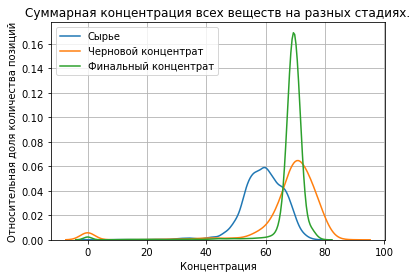

In [37]:
sns.kdeplot(raw, 
            label='Сырье'
           )
sns.kdeplot(draft, 
            label='Черновой концентрат'
           )
sns.kdeplot(final_concentrate, 
            label='Финальный концентрат'
           )
plt.grid()
plt.title('Суммарная концентрация всех веществ на разных стадиях.')
plt.xlabel('Концентрация')
plt.ylabel('Относительная доля количества позиций')
plt.legend(loc='upper left');

По сырью можно сказать, что концентрация находится на самом низком уровне и ее среднее в районе 56, а ее хвост слева не достигает и 80. У черногого концентрата схожий график с сырьем, но он значительно сдвинут к левой части графика и его среднее примерно равно 70 крайнее же левое значение в районе 90. Финальный концентрат имеет среднее схожее с черновым, но значительно опережает все остальные графики по количеству позиций в этом значении, что говорит о низком стандартном отклонении, и стремлении на данном этапе приблизица к этому значению. Максимальное значение у финального концентрата же меньше чем у черногого в районе 80. Можно сделать вывод, что после всех этапов отчистки, концентрация всех веществ стремится к значению 70, такую тенденцую скорее всего задает один из более сохранившихся элементов, в нашем случае золото, которое к финальному этапу составляет большую часть в каждой позиции.  
Также присутствуют значения в нуле, что может обьясняться аномалиями в значениях. Такие строчки, необходимо исключить из датасета для обучения модели, так как, в суммарной концентрации вещество, какой либо элемент должен присутствовать. 

Построим `Диаграмму размаха` и посмотрим на примерное количество выбросов, и после каких значений они находятся.

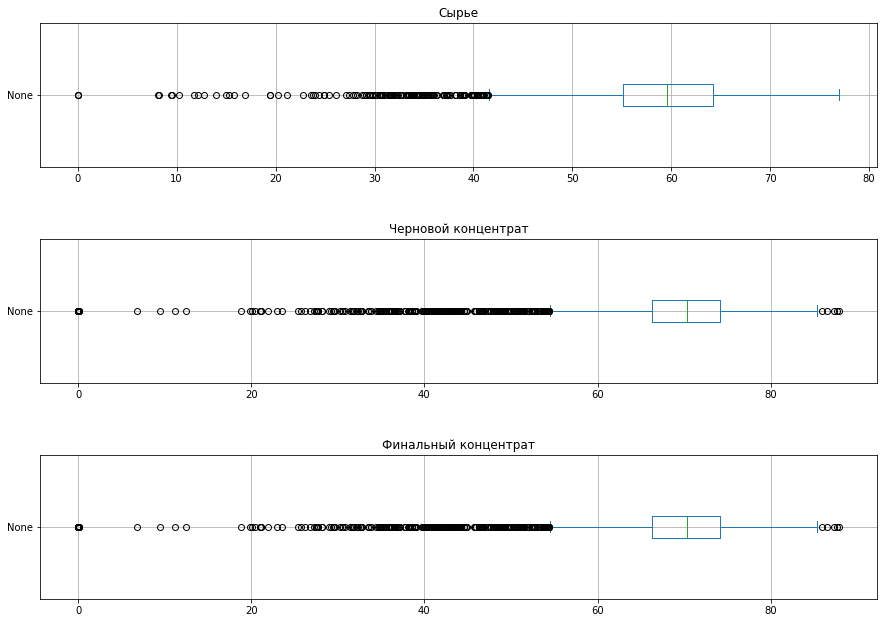

In [38]:

# Горизонтальный вид диаграммы размаха

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15,10))
ax1= raw.plot.box(vert = False, 
                  ax=ax1,
                  grid=True,
                  title='Сырье',
                  ylabel=''
                 )

ax2 = draft.plot.box(vert = False, 
                     ax=ax2,
                     grid=True,
                     title='Черновой концентрат',
                     ylabel=''
                    )
ax3 = draft.plot.box(vert = False, 
                     ax=ax3,
                     grid=True,
                     title='Финальный концентрат',
                     ylabel=''
                    )
#Для позиционирования
plt.subplots_adjust(hspace = 0.5, wspace=0.5, top=1, bottom=0.2)
plt.show()

На графике хорошо видны, значения после которых позиции принимают аномальные значения. Удалим данные значения из датасета `data_train_short` которым будем обучать наши модели. Но сначала найдем значения в 5%-ом доверительном интервале для каждого типа концентрата.

In [39]:
print('Начало доверительного интервала в 5% по сырью:', int(raw.quantile(0.025)))
print('Конец доверительного интервала в 95% по сырью:', int(raw.quantile(0.975)))
print()
print('Начало доверительный интервала в 5% по Черновому концентрату:', int(draft.quantile(0.025)))
print('Конец доверительного интервала в 95% по Черновому концентрату:', int(draft.quantile(0.975)))
print()
print('Начало доверительного интервала в 5% по Финальному концентрату:', int(final_concentrate.quantile(0.025)))
print('Конец доверительного интервала в 95% по Финальному концентрату:', int(final_concentrate.quantile(0.975)))

Начало доверительного интервала в 5% по сырью: 43
Конец доверительного интервала в 95% по сырью: 70

Начало доверительный интервала в 5% по Черновому концентрату: 0
Конец доверительного интервала в 95% по Черновому концентрату: 79

Начало доверительного интервала в 5% по Финальному концентрату: 49
Конец доверительного интервала в 95% по Финальному концентрату: 74


Значения после доверительного интервала, пожалуй оставим, для сохранения данных. Их несовсем много, и значения в них не совсем велики. Удалим их из датасета для обучения.

In [40]:
#Создаем переменную с индексами по сырью и удаляем из датасета для обучения
r_an = raw[raw<40].index
data_train_short = data_train_short.drop(index = r_an)
# Игнорируем ошибки таккак наверняка есть отсутствующие индексы
d_an = draft[draft<31].index
data_train_short = data_train_short.drop(index = d_an, 
                                         errors='ignore'
                                        )

f_an = final_concentrate[final_concentrate<57].index
data_train_short = data_train_short.drop(index = f_an, 
                                         errors='ignore'
                                        )

#Обновляем индексы
data_train_short = data_train_short.reset_index(drop=True)

Проверим количество потерянных данных.

In [41]:
 print(f'Процент потерянных данных составил: {round((len(data_train)-len(data_train_short)) / (len(data_train)/100),2)}%')

Процент потерянных данных составил: 7.71%


Было удаленно `6.19%`, это не критично, но все равно больше нормы равной в 5%. Оставим без изменений.

__Вывод__  
В данной части был проведен анализ данных и рассмотренно три вопроса.  
Было определенно, что после c каждым этапом отчистки концентрация элемента `ag` (серебра) стремительно уменьшается. Элемент `pb` (свинец), после флотации значительно возрос, а вот на финальной отчитке его концентрация выросла несильно. `Au` (золото) стремительно растетпосле каждого этапа, что неудивительно, так как цель сохранить этот элемент и преследуется компанией.  
Также был сделан вывод, что размер гранул в обучающей и тестовой выборке, значительно не отличаются, и влияние на обучение и проверку модели данный фактор будет иметь незначительный.  
В конце, было зафиксированно среднее значение общей концентрации элементов на финальном этапе отчистки в 70 единиц. Сырье же имело наименьшую концентрацию, скорее всего это обьясняется высоким присутствием большого количества других, неинтересующих нас, элементов. Также были удалены минимальные аномальные значения. Так как их влияние пагубно бы сыграло на обучении моделей.

## Модель

Пришло время построить модель которая будет предсказывать коэффициент восстановления золота из золотосодержащей руды. Качество модели будет отслеживать по метрике `sMAPE`. Для этого сначала создадим функцию которая по актуальным и предсказанным значением выдаст значчение этой метрики, а также функцию для подсчета совместной по обеим целевым признакам в которых значимать отличается 25% на флотацию и 75% на финальный этап отчистки.

__Функция расчета sMAPE__
___

In [42]:
#Функция для расчета отдельной sMAPE 
def smape(target_actual, target_predictions):
    numerator = np.abs(target_actual - target_predictions)
    denominator = (np.abs(target_actual) + np.abs(target_predictions)) / 2 
    return 1 / len(target_actual) * np.sum(numerator / denominator) * 100 

#Функция для расчета итоговой sMAPE по двум целевым признакам  
def calculate_final_smape(target_actual, target_predictions):
    target_actual_rougher = target_actual['rougher.output.recovery']
    target_actual_final = target_actual['final.output.recovery']
    target_predictions_rougher = target_predictions[:, 0]
    target_predictions_final = target_predictions[:, 1]
    return 0.25 * smape(target_actual_rougher, target_predictions_rougher) + 0.75 * smape(target_actual_final, target_predictions_final)

# Создаем дополнительную функцию оценки, по которой модели будут выбирать наилучшие параметры 
# и кроссвалидировать их
smape_scorer = make_scorer(calculate_final_smape, 
                           greater_is_better=False # Лучшей оценкой будет наименьшее значение
                          )

Функции разработаны, теперь можно приступить к обучению моделей.

__Обучение моделей для обоих целевых признаков__
___

Для обучения и проверки модели не обходимо в обучающую выборку разделить на целевые и определяющие параметры. Так как целевых параметров у нас два, переменная с целевыми параметрами будет содеражть две колонки.

In [43]:
features = data_train_short.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target = data_train_short[['rougher.output.recovery','final.output.recovery']]

Можно приступать к выбору моделей. Рассмотрим три известных мне метода обучения.  
* Линейную регрессию
* Дерево решений
* Случайный лес

Но для начала создадим константную модель находящую медиану, по таргету, которая поможет оценить адекватность обученных моделей. Но для того, чтобы применить крос-валидацию, используем метод `GridSearchCV` из библиотеки `sklearn`.

In [44]:
check_model = GridSearchCV(estimator=DummyRegressor(strategy = 'median'), # Вид модели
                            param_grid ={}, # обязательный аргумент принимает значение пустого словаря
                            scoring=smape_scorer # задаем оценку модели нашей функцией расчета итоговой sMAPE
                           )
# обучение модели
check_model.fit(features, target)


print('Среднее значение sMAPE на крос-валидации', 
      round(check_model.best_score_,4))
print('Значение sMAPE по всей обучающей выборке', 
      round(calculate_final_smape(target, check_model.predict(features)),4))

Среднее значение sMAPE на крос-валидации -9.1302
Значение sMAPE по всей обучающей выборке 8.4207


Как мы видим итоговые метрикии не сильно отличаются. Но стоит обьяснить минус на среднем значении на кросс-валидации. Он обусловлен особенностью расчетов библиотекой `sklearn`, для самоличносозданных метрик. Так что при оценки моделей, не будем на него обращать внимание, стоит учесть что чем ближе значение к нулю тем модель работает лучше.

__Линейная регрессия__
___

Для построения модели `Линейной регресии`, нет необходимости подбирать какие либо гипперпараметры.  Прогонять значения тренировочной выборки будет стандартное число раз заданное в данном методе `5`.

In [45]:
model_linear = GridSearchCV(estimator=LinearRegression(), # Вид модели
                            param_grid = {}, # обязательный аргумент принимает значение пустого словаря
                            scoring=smape_scorer # задаем оценку модели нашей функцией расчета итоговой sMAPE
                           )
# обучение модели
model_linear.fit(features, target)


print('Среднее значение sMAPE на крос-валидации', 
      round(model_linear.best_score_,4))
print('Значение sMAPE по всей обучающей выборке', 
      round(calculate_final_smape(target, model_linear.predict(features)),4))

Среднее значение sMAPE на крос-валидации -8.2914
Значение sMAPE по всей обучающей выборке 6.3941


Линейная регрессия как самая простая и быстрая показала результат в `8.4672` по среднему значению кросс-валидации, это больше чем у нашей проверочной модели. А значение целевой метрики по обучающей выборке, меньше чем у проверрочной.

__Случайный лес.__
___

Случайный лес имеет несколько важных гипперпараметров. При помощи той же `GridSearchCV`, подбирем наилучшие и применим кросс-валидацию.

In [46]:
param_rf = {'n_estimators': range (1, 21, 5),
            'max_depth': range (1, 10, 2),
            'random_state':[2503] # необходимо данный параметр заключить в список
            }

model_rf = GridSearchCV(estimator=RandomForestRegressor(), 
                        param_grid = param_rf, 
                        verbose=1, # Для отображения количества вариаций
                        scoring=smape_scorer # задаем оценку модели нашей функцией расчета итоговой sMAPE
                       )
# обучение модели
model_rf.fit(features, target)

print('Среднее значение sMAPE на крос-валидации', 
      round(model_rf.best_score_,4))
print('Значение sMAPE по всей обучающей выборке', 
      round(calculate_final_smape(target, model_rf.predict(features)),4))
print()
print('Наилучшие гипперпараметры :', end=' ')
print(f'деревья {model_rf.best_params_["max_depth"]} ; листья {model_rf.best_params_["n_estimators"]}')   

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Среднее значение sMAPE на крос-валидации -8.304
Значение sMAPE по всей обучающей выборке 5.0393

Наилучшие гипперпараметры : деревья 7 ; листья 16


У данной модели, результаты еще лучше. По все показателя модель опережает проверочную и линенйную регресию. Также есть возмжность подобрать другие гипперпараметры, для усовершенствования данной модели, но эта процедура может занять гараздо большее время. Останановимся на данном результате.

__Решающее деревою__
___


В данном случае, у нас останется только гипперпараметр `max_depht`.

In [47]:
param_dt = {'max_depth': range (1, 15, 1),
            'random_state':[2503] # необходимо данный параметр заключить в список
            }

model_dt = GridSearchCV(estimator=DecisionTreeRegressor(), 
                        param_grid = param_dt, 
                        verbose=1, # Для отображения количества вариаций
                        scoring=smape_scorer # задаем оценку модели нашей функцией расчета итоговой sMAPE
                       )
# обучение модели
model_dt.fit(features, target)

print('Среднее значение sMAPE на крос-валидации', 
      round(model_dt.best_score_,4))
print('Значение sMAPE по всей обучающей выборке', 
      round(calculate_final_smape(target, model_dt.predict(features)),4))
print()
print(f'Наилучшие гипперпараметр для "max_depth" {model_dt.best_params_["max_depth"]}')

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Среднее значение sMAPE на крос-валидации -8.8305
Значение sMAPE по всей обучающей выборке 7.3915

Наилучшие гипперпараметр для "max_depth" 1


Данная модель показала результат в на обучающей выборке `6.6085` и среднее значение `sMape` на кросс-валидации равное `8.1262`, который хуже чем у модели `Случайного леса`.

Выберем модель с наименьшим значением итоговой `sMAPE`. Этой моделью будет являтся `Случайный лес` с гиппер параметрами `max_depth`=3 и `n_estimators`=6 обученную выше. Осталось проверить ее качество на тестовой выборке.

__Проверка на тестовой выборке лучшей модели.__
___

Тестовые определяющии параметры хранятся в переменной `data_test`, а целевые признаки были заключен в переменной `target_test` в первой части работы. Найдем значение итоговой `sMAPE` для тестовой выборки.

In [48]:
# предсказываем результаты по тестовой выборке.
final_test_predict = calculate_final_smape(target_test, model_rf.predict(data_test))
print('Значение итогового sMAPE по тестовой выборке:', round(final_test_predict, 4))

Значение итогового sMAPE по тестовой выборке: 6.7955


Значение в `7.0943` конечно выше чем было достигнуто на этапе проверки модели, но разница составляет примерно в 1.
Можно заключить что модель работает достаточно эффективно. По ее выводу можно заключить, разработанная модель предсказывает коэффициент восстановления золота из золотосодержащей руды с ошибкой примерно равной `8-10%`.

__Вывод__   
В заключительной части, была разработанна функция дляоценки качества моделей метрикой `sMAPE`.  
Было рассмотренно три модели, из которых, как фоворит по метрике `sMAPE` была отобранна модель `Случайного леса`.  
Выбранная модель была проверенна на тестовой выборке, с неплохим результатом в `7.0943%`.

## Итоговый вывод

Данный проект был предназначен для разработки модели разработанная модель предсказывающей коэффициент восстановления золота из золотосодержащей руды. Так же был проведен анализ данных, и отвеченно на несколько вопросов, заданных в соответствующей части проекта. Но перед всей основной работой в первой части была проведенна предобработка данных. 
В заключении данной работы хотелось бы зафиксировать несколько моментов:

* Было определенно, что после c каждым этапом отчистки концентрация элемента ag (серебра) стремительно уменьшается. Элемент pb (свинец), после флотации значительно возрос, а вот на финальной отчитке его концентрация выросла несильн
и проверку модели данный фактор не имел.
* В конце, было зафиксированно среднее значение общей концентрации элементов в 70 единиц на финальном этапе отчистки, это данные по которым есть информация. Сырье же имело нименьшую концентрацию. Данные же которые содержали в себе аномальные значение (слишком низкие) было решенно удалить из датасета подготовленного для обучения моделй.
* Была разработанна функция для оценки качества моделей метрикой `sMAPE` с помощью которой была отобранна модель `Случайного леса`. Выбранная модель была проверенна на тестовой выборке, с результатом в `7.0943%`.